## Imports

In [4]:
# ------------------------------------------- importing dependencies ----------------------------------------
# import datetime
import os
# import random
import numpy as np
import pandas as pd
import math
import json
from IPython.display import clear_output
import sys,time
import warnings
import requests
import pickle
# !pip install neurokit2
import neurokit2 as nk
# !pip install -U scikit-learn
# !pip install ts2vg

from sklearn.preprocessing import MinMaxScaler, StandardScaler
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier#, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from scipy.io import loadmat
# !pip install tensorflow
# import tensorflow as tf
from sklearn.model_selection import train_test_split

# import matplotlib
import matplotlib.pyplot as plt

# from scipy import signal
# from scipy.signal import medfilt
# import pywt
# from pywt import wavedec

LIVE=True
# --------------------------------------------- parent db directory ------------------------------------------
DATASET_DIR = "./WFDB_ShaoxingUniv"
BASE_DIR = "./ECG_CSV_Selected"
RAW_DIR = "./ECG_RAW_selected"
SNOMED_PATH = "./SNOMED CT Codes.txt"
LABEL_PATH = "./Labels.txt"
LIST_PATH = "./edited_RECORDS.txt"
DF_PATH = "./DATAFRAME.csv"
BASIC_SRATE = 500 #Hz
TIME_PERIOD = 10 #secs

# Modelling Class Definition
#### Singular class to streamline data preprocessing and building diagnosis model

In [5]:
class ECG_hobenaki:
    def __init__(self, DATASET_DIR = DATASET_DIR, BASE_DIR =BASE_DIR, SNOMED_PATH = SNOMED_PATH, LABEL_PATH = LABEL_PATH, LIST_PATH = LIST_PATH, DF_PATH = DF_PATH, BASIC_SRATE = BASIC_SRATE, TIME_PERIOD = TIME_PERIOD):
        self.DATASET_DIR = DATASET_DIR
        self.BASE_DIR = BASE_DIR
        self.RAW_DIR = RAW_DIR
        self.SNOMED_PATH = SNOMED_PATH
        self.LABEL_PATH = LABEL_PATH
        self.LIST_PATH = LIST_PATH
        self.DF_PATH = DF_PATH
        self.TEST_PATH = './'
        self.gURL='http://192.168.0.100:3000/ecg-classifier' #GET request url for 3rd party applications
        self.pURL='http://192.168.0.100:3000/ecg-classifier' #POST request url for 3rd party applications
        
        #print('DATASET DIR ::',DATASET_DIR)
        # g_DATA = '.mat'
        # g_HEAD = '.hea'
        # g_leads = ['I','II','III','aVR']
        self.BASIC_SRATE = BASIC_SRATE #Hz
        self.TIME_PERIOD = TIME_PERIOD #sec
        # print('Basic sampling rate(Hz):', self.BASIC_SRATE)
        
        
    #Tags and filters data points based on SNOMED codes availability (SNOMED CT Codes.txt --> restricts which CVDs to train on) 
    def gen_rec(self,verbose=True):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            rec_list = os.listdir(self.DATASET_DIR)
            rec_count = 0 
            rec_count_expected = int(len(rec_list)/2)
            # rec_name_sep = ','
            rec_file = open('RECORDS.csv','w')
            rec_file.write(str(rec_count_expected))
            for f in rec_list:
                if f.endswith('.hea'):
                    rec_name = f[0:-4]
                    rec_file.write(','+rec_name) #<---- use skiprows=1 in np.loadtxt()
                    rec_count+=1
            rec_file.close()
            assert(rec_count_expected == rec_count) # should be equal
            load_txt = np.loadtxt('./RECORDS.csv', delimiter=',', dtype='str')
            rec_count = int(load_txt[0])
            rec_list = load_txt[1:]
            un_list = []
            for i in rec_list:
                with open(os.path.join(self.DATASET_DIR,i+'.hea')) as f:
                    hlines=f.readlines()
                    something = hlines[15][0:-1].split(" ")[1]
                    un_list+=list(something.split(","))
            un_list = list(set(un_list))
            #print(un_list)
            codeDict=dict()
            with open(self.SNOMED_PATH,"r") as f1:
                rL = f1.readlines()
                for line in rL:
                    x = line.strip().split("   ")
                    codeDict[x[1]] = x[0] #getting snomed-codes
            with open(self.LABEL_PATH,"w") as f2:
                labels = dict()
                for i in un_list:
                    if i in codeDict.keys():
                        labels[i] = codeDict[i] #populating labels for selected data
#                         if LABEL_PATH != "":
                        f2.write(i+" : "+codeDict[i]+"\n") #writing it in a file
            #getting the edited list of OK and labled patients
            with open(self.LIST_PATH,"w") as nf:
                edited_rec_list=[]
                for i in rec_list:
                    with open(os.path.join(self.DATASET_DIR,i+'.hea')) as f:
                        hlines=f.readlines()
                        codes =  list(hlines[15][0:-1].split(" ")[1].split(","))
                        flag = True
                        if codes == ["426783006"]:
        #                     OK_count+=1
                            flag = True                
                        else:
                            for c in codes:
                                if c not in labels.keys():
                                    flag = False
        #                             NO_count+=1
                                    break
                        if flag == True:
                            edited_rec_list.append(i)
#                             if LIST_PATH != "":
                            nf.write(i+"\n")
            if verbose:
                print("TOTAL RECORDS :: ",rec_count)
                print("UNIQUE CONDITIONS ::",len(un_list))
                print("AVAILABLE CODES",len(codeDict.keys()))
                print("NET RECORDS ::",len(edited_rec_list))    
        return edited_rec_list


    #Preprocesses raw ECG signal data and identifies R-Peaks in pulse (PQRST) intervals 
    def get_points(self,df_raw,collect=False,extra=True):    
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            ecg_signal=nk.ecg_clean(df_raw,sampling_rate=self.BASIC_SRATE)
            rpeaks = nk.ecg_peaks(ecg_signal, correct_artifacts=True, sampling_rate=self.BASIC_SRATE)[1]["ECG_R_Peaks"].tolist()
            waves_dwt = nk.ecg_delineate(ecg_signal, rpeaks, sampling_rate=self.BASIC_SRATE, method="dwt", show=True, show_type='peaks')[1]
            print(waves_dwt)
            points = dict()
            for key in waves_dwt.keys():
                points[key] = [i for i in waves_dwt[key] if math.isnan(i) != True]
                points['ECG_R_Peaks'] = rpeaks
            points['Heart_Rate'] = nk.ecg_rate(rpeaks,sampling_rate=self.BASIC_SRATE)
            if collect:
                with open("./Points_Info.txt", "a") as f:
                    f.write(rec[:-4]+"\n")
                    for i in points.keys():
                        f.write(i+" : "+str(points[i])+"\n")
                    f.write("\n\n")
            if extra:
                nk.signal_plot(nk.ecg_rsp(ecg_rate, sampling_rate=BASIC_SRATE))
            
        return points,ecg_signal
    
    #Performs feature engineering and generates train-(or test-)able dataframes
    def get_df(self,samples=-1,raw=True,collect=True,read=True):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            _path=self.BASE_DIR
            raw_path=self.RAW_DIR
            if read:
                with open(self.LIST_PATH) as f:
                    rec_list=f.readlines()
            else:
                rec_list=self.gen_rec()
            rec_list= rec_list if samples==-1 else rec_list[:samples]
            print(rec_list)
            _tot=len(rec_list)
            _cur=0
            dataDict = {k:[] for k in ["P_val","T_val","R_val","R_std","P_dur","T_dur","QRS_Complex","PR_itvl","ST_itvl","QT_itvl","QRS_perd","Heart_Rate","Arrhythmic_Anomaly","Structural_Anomaly","Scecondary_Anomaly","Uncharacterised_Anomaly"]}
            for rec in rec_list:
                fpath=raw_path+'/'+rec.strip()
                if raw:
                    f = loadmat(fpath+'.mat')
                    df_raw=pd.DataFrame(f['val']).T[1]
                else:
                    try:
                        fpath=_path+'/'+rec.strip()
                        df_raw=pd.read_csv(fpath+'.csv')['II']
                    except Exception as e:
                        f= open('./ERROR.txt','a')
                        f.write(rec.strip()+' : '+str(e)+'\n')
                        f.close
                        continue
                try:
#                     print(df_raw)
                    points,ecg_signal =self.get_points(df_raw)
#                     print(points)
                except Exception as ex:
                    f= open('./ERROR.txt','a')
                    f.write(rec.strip()+' : '+str(ex)+'\n')
                    f.close
                    continue
                with open(fpath+".hea",'r') as f:
                    Dx = f.readlines()[15][0:-1].split(" ")[1].split(",")
                    dataDict["P_val"].append(np.mean([ecg_signal[i] for i in points['ECG_P_Peaks']]))
                    dataDict["T_val"].append(np.mean([ecg_signal[i] for i in points['ECG_T_Peaks']]))
                    dataDict["R_val"].append(np.mean([ecg_signal[i] for i in points['ECG_R_Peaks']]))
                    dataDict["R_std"].append(np.std([ecg_signal[i] for i in points['ECG_R_Peaks']]))
                    dataDict["P_dur"].append(np.mean([(i[0]-i[-1])*0.002 for i in zip(points['ECG_P_Offsets'],points['ECG_P_Onsets'])]))
                    dataDict["T_dur"].append(np.mean([(i[0]-i[-1])*0.002 for i in zip(points['ECG_T_Offsets'],points['ECG_T_Onsets'])]))
                    dataDict["QRS_Complex"].append(np.mean([(i[0]-i[-1])*0.002 for i in zip(points['ECG_R_Offsets'],points['ECG_R_Onsets'])]))
                    dataDict["PR_itvl"].append(np.mean([(i[0]-i[-1])*0.002 for i in zip(points['ECG_R_Onsets'],points['ECG_P_Onsets'])]))
                    dataDict["ST_itvl"].append(np.mean([(i[0]-i[-1])*0.002 for i in zip(points['ECG_T_Onsets'],points['ECG_R_Offsets'])]))
                    dataDict["QT_itvl"].append(np.mean([(i[0]-i[-1])*0.002 for i in zip(points['ECG_T_Offsets'],points['ECG_R_Onsets'])]))
                    dataDict["QRS_perd"].append(np.mean([(points["ECG_R_Peaks"][i]-points["ECG_R_Peaks"][i-1])*0.002 for i in range(1,len(points['ECG_R_Peaks']))]))
                    dataDict["Heart_Rate"].append(np.mean(points['Heart_Rate']))
                    if set(Dx).intersection(set(['164889003','426761007', '713422000','164890007', '111975006', '164896001', '164947007', '49578007']))==set():
                        dataDict["Arrhythmic_Anomaly"].append(0)
                    else:
                        dataDict["Arrhythmic_Anomaly"].append(1)
                    if set(Dx).intersection(set(['164865005','55930002', '164873001','164917005']))==set():
                        dataDict["Structural_Anomaly"].append(0)
                    else:
                        dataDict["Structural_Anomaly"].append(1)
                    if set(Dx).intersection(set(['59931005', '164912004', '164917005']))==set():
                        dataDict["Scecondary_Anomaly"].append(0)
                    else:
                        dataDict["Scecondary_Anomaly"].append(1)
                    if set(Dx).intersection(set(['164934002','426995002','195101003','39732003', '39732003', '47665007','61721007','164937009']))==set():
                        dataDict["Uncharacterised_Anomaly"].append(0)
                    else:
                        dataDict["Uncharacterised_Anomaly"].append(1)
                _cur+=1
                _pctg=int(np.round(_cur/_tot*100))
                clear_output(wait=True)
                print("Processed:\t["+"#"*(_pctg//4)+" "*(25-_pctg//4)+"]\t"+str(_pctg)+"%")
    #                 sys.stdout.flush()
            if collect:
                df = pd.DataFrame(dataDict)
                df.to_csv(self.DF_PATH)
        return(df)
    
    
    
    #For visualizing raw ECG signals
    def ecg_viz(self,PATH,raw=False):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            if raw:
                f = loadmat(PATH)
                df_=pd.DataFrame(f['val']).T
                att=1
            else:
                df_= pd.read_csv(PATH)
                att='II'
    #         df["ECG"].plot()
            nk.ecg_plot(nk.ecg_process(df_[att])[0], sampling_rate=self.BASIC_SRATE, show_type='default')

        
    #Generates multi-labelled target(s) for sample data
    def df_classes(self,read=True):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            if read:
                df=pd.read_csv(self.DF_PATH)
                df.drop(['Unnamed: 0'],axis=1,inplace=True)
            else:
                df=self.get_df()                
            Y = []
            # print(df.shape())
            for i in range(df.shape[0]):
                Y.append(str(df.iloc[i,-4])+str(df.iloc[i,-3])+str(df.iloc[i,-2])+str(df.iloc[i,-1]))
            for i in ['0','1']:
                for j in ['0','1']:
                    for k in ['0','1']:
                        for l in ['0','1']:
                            x=i+j+k+l
                            print(x,Y.count(x))
                            
    #Performs Train-Test-Splitting and Trains Model(Random Forest)                        
    def ml_train(self,seed=0,read=True):
#         with warnings.catch_warnings():
#             warnings.simplefilter("ignore", category=RuntimeWarning)
        if read:
            df=pd.read_csv(self.DF_PATH)
            df.drop(['Unnamed: 0'],axis=1,inplace=True)
        else:
            df = self.get_df(read=False)
        X=df.iloc[:,:-4].values
        o=[set(i) for i in np.isnan(X)]
        o_=[i for i in range(len(o)) if o[i] == {False,True}]
#         print(o_[:5])
        df.drop(df.index[o_],inplace=True)
        df.to_csv('./DF_edited.csv')
        X=df.iloc[:,:-4].values.tolist()
        Y=df.iloc[:,-4:].values.tolist()
        self.X_train,self.X_test,self.Y_train,self.Y_test=train_test_split(X,Y,test_size=0.3,random_state=seed)
        self.reading=df.iloc[4,:-4].values.tolist()
#         print(self.reading)
#         self.X_train,self.X_validate,self.Y_train,self.Y_validate=train_test_split(X_train,Y_train,test_size=0.2,random_state=seed)
        clf = RandomForestClassifier(oob_score=True,n_jobs=-1,class_weight='balanced_subsample',random_state=seed)#n_estimators=200,max_features=None,oob_score=True,
        clf.fit(self.X_train,self.Y_train)
        print("Model Accuracy :",np.round(clf.score(self.X_test,self.Y_test)*100,2),"%")
        self.model = clf
#         parameters = {
#             'n_estimators' : [25,50,100,125,150,200,225,250],
#             "criterion" : ["gini", "entropy", "log_loss"],
#             "max_depth" : [None,2,4,6,8,10,12,14,16,18,20],
#             "max_features" : ["sqrt", "log2", None],
#             "bootstrap" : [True,False],
#             "oob_score" : [True,False]
#         }
        parameters = {
                'n_estimators' : [100,150,200],
                'criterion' : ["gini", "entropy", "log_loss"],
                'max_depth' : [10,15,None],
                'max_features' : ["sqrt", "log2",None],
        }
#         clf_ = GridSearchCV(clf,parameters,scoring=accuacy_score,n_jobs=-1,oob_score=True,return_train_score=True)
#         clf_.fit(self.X_train,self.Y_train)
#         print("Model Accuracy :",np.round(clf_.score(self.X_test,self.Y_test)*100,2),"%")  
#         self.model = clf_.best_estimator_
        
#         x = clf_.cv_results_['rank_test_score']
#         y = clf_.cv_results_['mean_test_score']
#         plt.bar(x, y)
#         plt.xlabel('Model Variation')
#         plt.ylabel('Score')
#         plt.title('Hyper-parm Tuning')
#         plt.show()

#         print(clf_.cv_results_)
        pickle.dump(self.model, open('./model.sav', 'wb'))
        
    #For testing unseen data on trained model    
    def ml_test(self,live=False):
        if live:
            signal_raw=[]
    #         for i in range(2000):
            input_=requests.get(self.gURL).text
            j_=json.loads(input_)
            signal_raw = [j_[i] for i in j_.keys()]
    #         signal_raw+=j_.lstrip('{"ECG": ').rstrip('}').split(', "ECG": ')
            points,ecg_signal=self.get_points(signal_raw,False)
            dataDict = {k:[] for k in ["P_val","T_val","R_val","R_std","P_dur","T_dur","QRS_Complex","PR_itvl","ST_itvl","QT_itvl","QRS_perd","Heart_Rate"]}
            dataDict["P_val"].append(np.mean([ecg_signal[i] for i in points['ECG_P_Peaks']]))
            dataDict["T_val"].append(np.mean([ecg_signal[i] for i in points['ECG_T_Peaks']]))
            dataDict["R_val"].append(np.mean([ecg_signal[i] for i in points['ECG_R_Peaks']]))
            dataDict["R_std"].append(np.std([ecg_signal[i] for i in points['ECG_R_Peaks']]))
            dataDict["P_dur"].append(np.mean([(i[0]-i[-1])*0.002 for i in zip(points['ECG_P_Offsets'],points['ECG_P_Onsets'])]))
            dataDict["T_dur"].append(np.mean([(i[0]-i[-1])*0.002 for i in zip(points['ECG_T_Offsets'],points['ECG_T_Onsets'])]))
            dataDict["QRS_Complex"].append(np.mean([(i[0]-i[-1])*0.002 for i in zip(points['ECG_R_Offsets'],points['ECG_R_Onsets'])]))
            dataDict["PR_itvl"].append(np.mean([(i[0]-i[-1])*0.002 for i in zip(points['ECG_R_Onsets'],points['ECG_P_Onsets'])]))
            dataDict["ST_itvl"].append(np.mean([(i[0]-i[-1])*0.002 for i in zip(points['ECG_T_Onsets'],points['ECG_R_Offsets'])]))
            dataDict["QT_itvl"].append(np.mean([(i[0]-i[-1])*0.002 for i in zip(points['ECG_T_Offsets'],points['ECG_R_Onsets'])]))
            dataDict["QRS_perd"].append(np.mean([(points["ECG_R_Peaks"][i]-points["ECG_R_Peaks"][i-1])*0.002 for i in range(1,len(points['ECG_R_Peaks']))]))
            dataDict["Heart_Rate"].append(np.mean(points['Heart_Rate']))
    #         print(dataDict)
            X = pd.DataFrame(dataDict)
            X = X.values.tolist()
        else:
#             X = self.reading
            X=requests.get('http://127.0.0.1:8080/').json()['message']
#             model=self.model
        model = pickle.load(open('./model.sav', 'rb'))
        results = model.predict([X])[0]
        labels=["Arrhythmic_Beat","Structural_Condition","Scecondary_Causality","Uncharacterised_Anomaly"]
        temp=' '.join([l*i for l,i in zip(labels,results)])
#         print(temp.strip().split(' '))
        if temp.strip().split(' ')==['']:
            suggestion="Cheers to a healthy heart!"
        elif len(temp.strip().split(' '))==1:
            suggestion="Try to be less stressed and care for your health."
        elif len(temp.strip().split(' '))==2:
            suggestion="Perhaps start looking for a professional opinion."
        else:
            suggestion="Seek help immediately!"
        data_=json.dumps({"Abnormalities":temp.strip(), "Remarks":suggestion}, indent=4)
        print(data_)
        if live:
            print("OK :",requests.post(self.pURL,data=data_, headers={'Content-type': 'application/json'}).ok,"")
#         time.sleep(10)
#     def driver(self,live=False):
#         with warnings.catch_warnings():
#             warnings.simplefilter("ignore", category=RuntimeWarning)
#             self.ml_train()
# #             self.ml_test(live)
            

# Training & Testing the Model

In [6]:
obj = ECG_hobenaki() #Instantiating diagnosis-class object

In [7]:
obj.ml_train() #Training Model

Model Accuracy : 71.95 %


In [13]:
obj.ml_test() #Testing model on unseen data

{
    "Abnormalities": "",
    "Remarks": "Cheers to a healthy heart!"
}


['Arrhythmic_Beat']
{
    "Abnormalities": "Arrhythmic_Beat",
    "Remarks": "Try to be less stressed and care for your health."
}
OK : True 


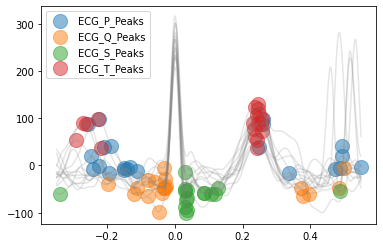

In [9]:
obj.ml_test(LIVE) #Testing model on 3rd party application reading

#### Testing 3rd Party Connection 

In [ ]:
_=pd.read_csv('./ECG_CSV_Selected/JS00036.csv')['II'].values.tolist()
with open("./JS00036.json", "w") as outfile:
    json.dump({str(i):_[i] for i in range(len(_))}, outfile)

#         print(L)

In [ ]:
with open("./JS00036.json", "r") as F:
    L = F.readline().lstrip('{').rstrip('}').split(', ')
L_=[]
for i in L:
    L_.append(i.split(': ')[1])
for i range(0,len(L_),5):
    tmp=L_[i:i+5]
    X_="{}"
    for j in range(len(tmp)):
        X_=X_[:-1]+"ECG: "+X_[-1]
print(L_)

In [ ]:
_=pd.read_csv('./ECG_CSV_Selected/JS00008.csv')['II'].values.tolist()
print(_)
with open("./JS00008.json", "w") as outfile:
    temp_={"ECG":i for i in _}
    print(temp_)
    json.dump(temp_, outfile)
    
_=pd.read_csv('./ECG_CSV_Selected/JS00036.csv')['II'].values.tolist()
with open("./JS00036.json", "w") as outfile:
    json.dump({"ECG":_[i] for i in range(len(_))}, outfile)

In [ ]:
fpath=RAW_DIR+'/'+'JS00008'
f = loadmat(fpath+'.mat')
df_raw=pd.DataFrame(f['val']).T[1]
print(df_raw)
# print(np.min(df_raw),np.max(df_raw))
scaler = StandardScaler()#feature_range=(0, 1))
scaler.fit_transform([df_raw])

In [ ]:
import flask
from flask import Flask, jsonify

app = Flask(__name__)

@app.route('/', methods=['GET'])
def handle_get_request():
    # Handle the GET request
    response = {'message': [75.97590036468894, 86.98580872111783, 552.4224999322945, 33.287520094430775, 0.1016666666666666, 0.1005, 0.107, 0.1413333333333333, 0.1903333333333333, 0.3978333333333333, 0.7870909090909091, 76.23266457763836]}
    return jsonify(response)

if __name__ == '__main__':
    app.run(host='127.0.0.1', port='8080')


## Experimenting with Alternative ML Models

### Setting up baseline estimator with XGBoost Default classfier on MultiLabelled Data

In [9]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.datasets import make_multilabel_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


# X, y = make_multilabel_classification(n_samples=11217, n_features=12, n_classes=4, n_labels=2,
#                                       allow_unlabeled=False, random_state=0)
# X = scaler.fit_transform(X)
scaler = StandardScaler()
df = pd.read_csv('./DF_edited.csv')
df.drop(['Unnamed: 0'],axis=1,inplace=True)
X=pd.DataFrame(scaler.fit_transform(pd.DataFrame(df.iloc[:,:-4].values.tolist())))
Y=pd.DataFrame(df.iloc[:,-4:].values.tolist())

# split dataset into training and test set
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

clf = xgb.XGBClassifier(objective='binary:logistic',tree_method="hist", learning_rate=0.1)
clf.fit(X_train, y_train)
print('F1-Score on test data: {:.1f}%'.format(f1_score(y_test, clf.predict(X_test), average='samples', zero_division=np.nan)*100))

F1-Score on test data: 84.1%


In [10]:
clf.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': 'hist',
 'validate_parameters': None,
 'verbosity': None}

### XGBoost with MultiOutputClassifier

In [7]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler


# create sample dataset
# X, y = make_multilabel_classification(n_samples=11215, n_features=12, n_classes=4, n_labels=2,
#                                       allow_unlabeled=False, random_state=0)
# X = scaler.fit_transform(X)
scaler = StandardScaler()
df = pd.read_csv('./DF_edited.csv')
df.drop(['Unnamed: 0'],axis=1,inplace=True)
X=pd.DataFrame(scaler.fit_transform(pd.DataFrame(df.iloc[:,:-4].values.tolist())))
Y=pd.DataFrame(df.iloc[:,-4:].values.tolist())

# split dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# create XGBoost instance with default hyper-parameters
xgb_estimator = xgb.XGBClassifier(objective='binary:hinge',tree_method="hist", learning_rate=0.1)

# create MultiOutputClassifier instance with XGBoost model inside
multilabel_model = MultiOutputClassifier(xgb_estimator,n_jobs=-1)

# fit the model
multilabel_model.fit(X_train, y_train)

# evaluate on test data
print('F1-Score on test data: {:.1f}%'.format(f1_score(y_test, multilabel_model.predict(X_test), average='samples', zero_division=np.nan)*100))

F1-Score on test data: 84.4%


In [8]:
multilabel_model.get_params()

{'estimator__objective': 'binary:hinge',
 'estimator__use_label_encoder': None,
 'estimator__base_score': None,
 'estimator__booster': None,
 'estimator__callbacks': None,
 'estimator__colsample_bylevel': None,
 'estimator__colsample_bynode': None,
 'estimator__colsample_bytree': None,
 'estimator__early_stopping_rounds': None,
 'estimator__enable_categorical': False,
 'estimator__eval_metric': None,
 'estimator__feature_types': None,
 'estimator__gamma': None,
 'estimator__gpu_id': None,
 'estimator__grow_policy': None,
 'estimator__importance_type': None,
 'estimator__interaction_constraints': None,
 'estimator__learning_rate': 0.1,
 'estimator__max_bin': None,
 'estimator__max_cat_threshold': None,
 'estimator__max_cat_to_onehot': None,
 'estimator__max_delta_step': None,
 'estimator__max_depth': None,
 'estimator__max_leaves': None,
 'estimator__min_child_weight': None,
 'estimator__missing': nan,
 'estimator__monotone_constraints': None,
 'estimator__n_estimators': 100,
 'estimato

### LightGBM with MultiOutputClassifier

In [5]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler


# create sample dataset
# X, y = make_multilabel_classification(n_samples=11215, n_features=12, n_classes=4, n_labels=2,
#                                       allow_unlabeled=False, random_state=0)
# X = scaler.fit_transform(X)
scaler = StandardScaler()
df = pd.read_csv('./DF_edited.csv')
df.drop(['Unnamed: 0'],axis=1,inplace=True)
X=pd.DataFrame(scaler.fit_transform(pd.DataFrame(df.iloc[:,:-4].values.tolist())))
Y=pd.DataFrame(df.iloc[:,-4:].values.tolist())

# split dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# create XGBoost instance with default hyper-parameters
lgb_estimator = lgb.LGBMClassifier(objective='binary')

# create MultiOutputClassifier instance with XGBoost model inside
multilabel_model = MultiOutputClassifier(lgb_estimator,n_jobs=-1)

# fit the model
multilabel_model.fit(X_train, y_train)

# evaluate on test data
print('F1-Score on test data: {:.1f}%'.format(f1_score(y_test, multilabel_model.predict(X_test), average='samples', zero_division=np.nan)*100))

F1-Score on test data: 83.9%


In [6]:
multilabel_model.get_params()

{'estimator__boosting_type': 'gbdt',
 'estimator__class_weight': None,
 'estimator__colsample_bytree': 1.0,
 'estimator__importance_type': 'split',
 'estimator__learning_rate': 0.1,
 'estimator__max_depth': -1,
 'estimator__min_child_samples': 20,
 'estimator__min_child_weight': 0.001,
 'estimator__min_split_gain': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__num_leaves': 31,
 'estimator__objective': 'binary',
 'estimator__random_state': None,
 'estimator__reg_alpha': 0.0,
 'estimator__reg_lambda': 0.0,
 'estimator__subsample': 1.0,
 'estimator__subsample_for_bin': 200000,
 'estimator__subsample_freq': 0,
 'estimator': LGBMClassifier(objective='binary'),
 'n_jobs': -1}

#### Samples per class (combination of values of each y-column)

In [4]:
df = pd.read_csv('./DF_edited.csv')
df.drop(['Unnamed: 0'],axis=1,inplace=True)
s=0
print(f"Class Combinations:\n{sorted(list(set([' '.join(list(map(str,item))) for item in df.iloc[:,-4:].values.tolist()])))}")
print()
print()
for i in sorted(list(set([' '.join(list(map(str,item))) for item in df.iloc[:,-4:].values.tolist()]))):
    s+=[' '.join(list(map(str,item))) for item in df.iloc[:,-4:].values.tolist()].count(i)
    print(f"Class:\t{i}\t\tSamples:\t{[' '.join(list(map(str,item))) for item in df.iloc[:,-4:].values.tolist()].count(i)}")

print()
print()
print(f"Net Sample Count{s}")

Class Combinations:
['0 0 0 0', '0 0 0 1', '0 0 1 0', '0 0 1 1', '0 1 0 0', '0 1 0 1', '0 1 1 0', '0 1 1 1', '1 0 0 0', '1 0 0 1', '1 0 1 0', '1 0 1 1', '1 1 0 0', '1 1 0 1', '1 1 1 0', '1 1 1 1']


Class:	0 0 0 0		Samples:	5904
Class:	0 0 0 1		Samples:	535
Class:	0 0 1 0		Samples:	36
Class:	0 0 1 1		Samples:	55
Class:	0 1 0 0		Samples:	146
Class:	0 1 0 1		Samples:	9
Class:	0 1 1 0		Samples:	37
Class:	0 1 1 1		Samples:	15
Class:	1 0 0 0		Samples:	2219
Class:	1 0 0 1		Samples:	1160
Class:	1 0 1 0		Samples:	36
Class:	1 0 1 1		Samples:	165
Class:	1 1 0 0		Samples:	658
Class:	1 1 0 1		Samples:	117
Class:	1 1 1 0		Samples:	57
Class:	1 1 1 1		Samples:	68


Net Sample Count11217
